# Question A4

In this section, we will understand the utility of such a neural network in real world scenarios.

#### Please use the real record data named ‘record.wav’  as a test sample. Preprocess the data using the provided preprocessing script (data_preprocess.ipynb) and prepare the dataset.
Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons.
Find the most important features on the model prediction for the test sample using SHAP. Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)



1. Firstly, we import relevant libraries.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

To reduce repeated code, place your
network (MLP defined in QA1)
torch datasets (CustomDataset defined in QA1)
loss function (loss_fn defined in QA1)
in a separate file called common_utils.py

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.


In [2]:
# YOUR CODE HERE
np.random.seed(42)
from common_utils import CustomDataset, loss_fn, split_dataset, preprocess_dataset

class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        super(MLP, self).__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(no_hidden, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),

            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            
            nn.Linear(128, no_labels),
            nn.Sigmoid()            
        )

    # YOUR CODE HERE
    def forward(self, x):
        logits = self.mlp_stack(x)
        return logits

2. Install and import shap

In [3]:
# YOUR CODE HERE
import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


3. Read the csv data preprocessed from 'record.wav', using variable name 'df', and fill the size of 'df' in 'size_row' and 'size_column'.

In [4]:
df = pd.read_csv('new_record.csv')
size_row = 0
size_column = 0
# YOUR CODE HERE
size_row, size_column = df.shape
df

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,...,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,record.wav,112.347147,51,25.5,0.478361,0.111058,0.579547,0.091646,0.268037,0.01149,...,-4.068467,46.232433,-4.134901,53.040028,-0.942353,35.105545,-3.529712,54.78144,-3.722852,53.242016


 4.  Preprocess to obtain the test data, save the test data as numpy array.

In [5]:
def preprocess(X_train, df):
    """preprocess your dataset to obtain your test dataset, remember to remove the 'filename' as Q1
    """
    # YOUR CODE HERE
    
    X_test = df.drop('filename', axis=1, inplace=False)
    X_train_scaled, X_test_scaled_eg = preprocess_dataset(X_train, X_test)
    
    return X_test_scaled_eg

X_train = pd.read_csv('simplified.csv')
X_train.drop('filename', axis=1, inplace=True)
X_test_scaled_eg = preprocess(X_train, df)
# print(X_test_scaled_eg)
# print(X_test_scaled_eg.shape[1])

5. Do a model prediction on the sample test dataset and obtain the predicted label using a threshold of 0.5. The model used is the optimized pretrained model using the selected optimal batch size and optimal number of neurons. Note: Please define the variable of your final predicted label as 'pred_label'.

In [6]:
# YOUR CODE HERE
model = MLP(no_features=X_test_scaled_eg.shape[1], no_hidden=256, no_labels=2)
model.load_state_dict(torch.load('../second_model.pth'))
model.eval()
threshold = 0.5
with torch.no_grad():
    # Pass the test data through the loaded model
    predictions = model(torch.Tensor(X_test_scaled_eg))
pred_label = (predictions >= threshold).to(torch.int)
print(predictions)
print(pred_label)

tensor([[0.0225, 0.9756]])
tensor([[0, 1]], dtype=torch.int32)


6. Find the most important features on the model prediction for your test sample using SHAP. Create an instance of the DeepSHAP which is called DeepExplainer using traianing dataset: https://shap-lrjball.readthedocs.io/en/latest/generated/shap.DeepExplainer.html.

Plot the local feature importance with a force plot and explain your observations.  (Refer to the documentation and these three useful references:
https://christophm.github.io/interpretable-ml-book/shap.html#examples-5,
https://towardsdatascience.com/deep-learning-model-interpretation-using-shap-a21786e91d16,  
https://medium.com/mlearning-ai/shap-force-plots-for-classification-d30be430e195)


Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
CUDA initialization: The NVIDIA driver on your system is too old (found version 11020). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ..\c10\cuda\CUDAFunctions.cpp:108.)


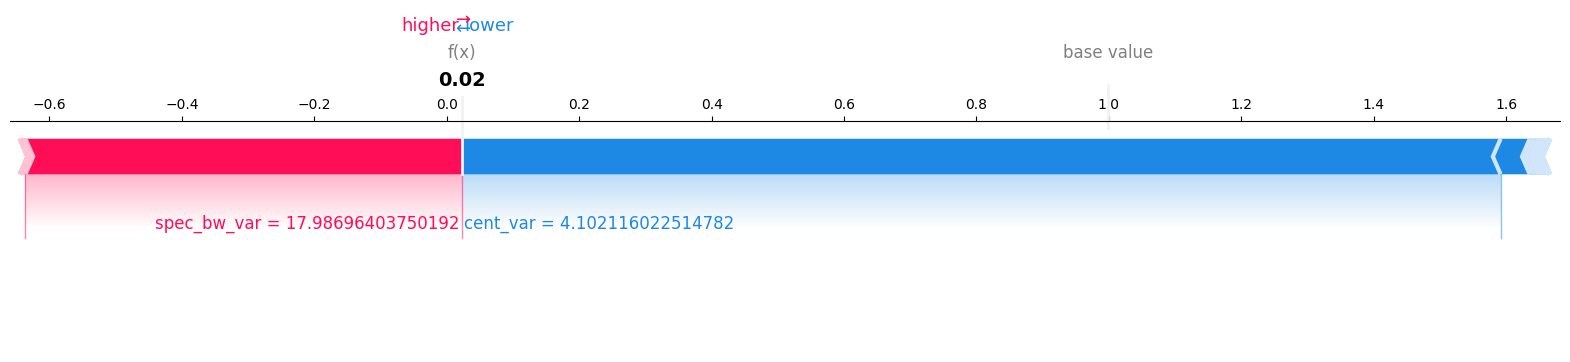

In [7]:
'''
Fit the explainer on a subset of the data (you can try all but then gets slower)
Return approximate SHAP values for the model applied to the data given by X.
Plot the local feature importance with a force plot and explain your observations.
'''
# YOUR CODE HERE
X_train_numpy = X_train.values.astype(np.float32)

# Convert the NumPy array to a PyTorch tensor
X_train_tensor = torch.tensor(X_train_numpy)
X_test_tensor = torch.tensor(X_test_scaled_eg, dtype=torch.float32)
# Now, you can create the DeepExplainer instance
explainer = shap.DeepExplainer(model, X_train_tensor)

# print(X_train_tensor[:400].shape)
# print(X_test_scaled_eg.shape)

shap_values = explainer.shap_values(X_test_tensor)

# print(explainer.expected_value)
# print(shap_values)
# print(X_train.columns)
class_index = 0
# Create a force plot for the explanation
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_scaled_eg, feature_names=X_train.columns, matplotlib=True)

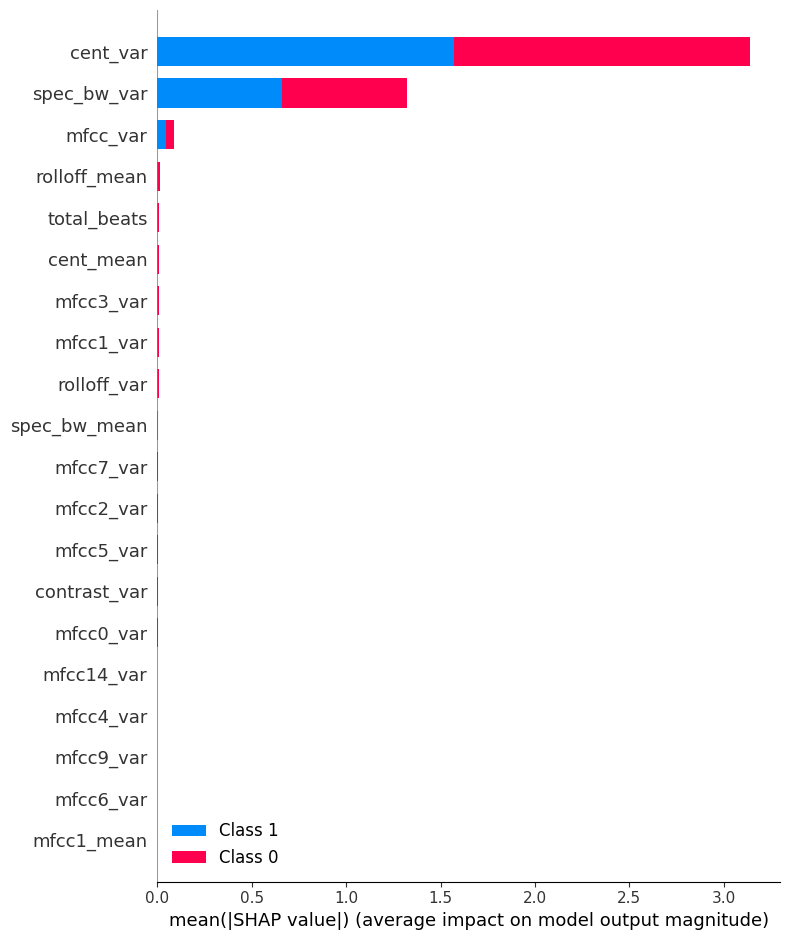

In [9]:
shap.summary_plot(shap_values, X_test_scaled_eg, feature_names=X_train.columns.tolist(), show=False) # Plot local feature importance with a summary plot
plt.show() 

In [8]:
explanation_of_force_plots = """the base value probability (average predicted probability) for the force plot is 0.02. Feature spec_bw_var contributes to increasing the probability whereas cent_var contributes to decreasings the probability. The average impact on model output can be further understood by the summary plot"""

the base value probability (average predicted probability) for the first plot is 0.02. Feature spec_bw_var contributes to increasing the probability whereas cent_var contributes to decreasing the probability.
